# Import the necessary libraries

In [15]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.linalg import block_diag

# NAR Model
To prepare for training our model, it is convenient to express it in the following form :

\begin{equation}\label{eq:regr}
\mathbb{Y}_t = \mathbb{X}_{t-1} \beta + \epsilon_t
\end{equation}

where
\begin{equation}
\mathbb{X}_{t-1} := \begin{bmatrix} X_{t-1} & X_{t-2} & \ldots & X_{t-q} & \operatorname{diag}(\mathbb{Z}_{1(t-1)}) & \ldots & \operatorname{diag}(\mathbb{Z}_{p(t-1)}) \end{bmatrix}
\end{equation}

\begin{equation}
X_{t-k} := \begin{bmatrix} \operatorname{diag}(\mathbb{Y}_{t-k}) & \operatorname{diag}(W\mathbb{Y}_{t-k}) \end{bmatrix}, k =1, \ldots, q
\end{equation}

\begin{equation}
\beta := \begin{bmatrix} \alpha_1^\top & \alpha_2^\top & \ldots & \alpha_q^\top & \gamma_1^\top & \ldots & \gamma_p^\top \end{bmatrix}^\top
\end{equation}

\begin{equation}
\alpha_l = \begin{bmatrix} a_1^{(l)} & a_2^{(l)} & \ldots & a_N^{(l)} & b_1^{(l)} & b_2^{(l)} & \ldots & b_N^{(l)} = \end{bmatrix}^\top, \quad l = 1, 2, \ldots, q
\end{equation}

\begin{equation}
\gamma_k = \begin{bmatrix} c_{1k} & c_{2k} & \ldots & c_{Nk} \end{bmatrix}^\top, \quad k = 1, 2, \ldots, p
\end{equation}
This matrix formulation is useful because it allows us to apply linear regression algorithms to estimate the coefficients $\beta$.

In [16]:
def compute_X_t_minus_1(Y, Z, W, q_1, q_2, t):
    """
    Returns the matrix X_{t-1} for the time step t
    Each time we use an index of a matrix (for exemple t-l), we subtract 1 from it
    """
    #define dimensions
    N, T = Y.shape[0], Y.shape[1]
    p = Z.shape[2]
    q = max(q_1, q_2)

    X_t_minus_l = []
    for l in range(1, q+1):
        if t-l-1 < 0:
            X_t_minus_l.append(np.zeros((N, 2*N)))
        else:
            X_t_minus_l.append(np.hstack((np.diag(Y[:, t-l-1]), np.diag(np.dot(W,Y[:, t-l-1])))))

    for k in range(1,p+1):
        X_t_minus_l.append(np.diag(Z[:, t-1-1, k-1]))

    return np.hstack(X_t_minus_l)

In [17]:
def get_a_b_c(N, T, p, q, beta):
    """
    Given the parameters of the model, returns the matrices a, b, and c
    """
    a = np.zeros((N, q))
    b = np.zeros((N, q))
    c = np.zeros((N, p))
    for i in range(q):
        a[:, i] = beta[2*N*i : 2*N*i + N].reshape(-1)
        b[:, i] = beta[2*N*i + N : 2*N*i + 2*N].reshape(-1)
    for i in range(p):
        c[:, i] = beta[2*N*q + i*N : 2*N*q + i*N + N].reshape(-1)
    return a, b, c

def compute_response_Y_t_node_i(Y, Z, W, t, q_1, q_2, beta, i):
    """
    Computes the response at time t using the explicit NAR formula
    """
    N, T = Y.shape[0], Y.shape[1]
    p = Z.shape[2]
    q = max(q_1, q_2)
    a, b, c = get_a_b_c(N, T, p, q, beta)
    sum1 = 0
    sum2 = 0

    for j in range(1, q+1):
        sum1 += a[i-1, j-1] * Y[i-1, t-j-1]

    for j in range(1, q+1):
        inner_sum = 0
        for k in range(1, N+1):
            inner_sum += W[i-1, k-1] * Y[k-1, t-j-1]
        sum2 += b[i-1, j-1] * inner_sum
    
    covariate_term = c[i-1, :] @ Z[i-1, t-1-1, :]

    return sum1 + sum2 + covariate_term

# OLS estimator
We will begin by exploring the simplest and most commonly used estimator for this type of problem: the Ordinary Least Squares (OLS) estimator. The OLS estimator is widely favored due to its simplicity and ease of implementation:

\begin{equation}
    \hat{\beta}_{OLS} = (\sum_{t=1}^T \mathbb{X}_{t-1}^\top \mathbb{X}_{t-1})^{-1} \sum_{t=1}^T \mathbb{X}_{t-1}^\top \mathbb{Y}_t
\end{equation} 

In [18]:
def compute_beta_OLS(Y, Z, W, q_1, q_2, l_1=1, l_2=2, l_3=1, testing = False):
    """
    Returns the OLS estimator for the parameters beta
    """
    #define dimensions
    N, T = Y.shape[0], Y.shape[1]
    p = Z.shape[2]
    q = max(q_1, q_2)
    firstSum = np.zeros((2*N*q+N*p, 2*N*q+N*p))
    secondSum = np.zeros((2*N*q+N*p, 1))
    if testing:
        s=q
    else:
        s=0
    for t in range(s+1, T+1):
        X_t_minus_1 = compute_X_t_minus_1(Y, Z, W, q_1, q_2, t)
        firstSum += X_t_minus_1.T @ X_t_minus_1
        secondSum += X_t_minus_1.T @ (Y[:,t-1])[:, np.newaxis]
    
    blocks=[]
    I_N_1 = (1/np.sqrt(T-s)) * l_1 * np.eye(N)
    I_N_2 = (1/np.sqrt(T-s)) * l_2 * np.eye(N)
    I_Np_3 = (1/np.sqrt(T-s)) * l_3 * np.eye(N*p)
    for i in range(0,q):
        blocks.append(I_N_1)
        blocks.append(I_N_2)
    blocks.append(I_Np_3)
    
    M = block_diag(*blocks)
    
    firstSum += (T-s)*M
    beta = np.linalg.inv(firstSum) @ secondSum
    return beta

def compute_response_Y_t(Y, Z, W, q_1, q_2, t, beta):
    """
    Returns the vector Y_t at time step t given the matrix X_{t-1} and the vector beta
    """
    return compute_X_t_minus_1(Y, Z, W, q_1, q_2, t) @ beta

# GLS estimator
However, the OLS estimator ignores the covariance structure of the error term. If we want to incorporate them in our estimator, we can use the GLS estimator defined as follows:

\begin{equation}
    \hat{\beta}_{GLS} = (\sum_{t=1}^T \mathbb{X}_{t-1}^\top \Sigma_\varepsilon^{-1} \mathbb{X}_{t-1})^{-1} \sum_{t=1}^T \mathbb{X}_{t-1}^\top \Sigma_\varepsilon^{-1} \mathbb{Y}_t
\end{equation}

In [19]:
def compute_residuals(Y, Z, W, q_1, q_2):
    """
    Returns the residuals for the time series Y
    """
    #define dimensions
    N, T = Y.shape[0], Y.shape[1]
    p = Z.shape[2]

    beta = compute_beta_OLS(Y, Z, W, q_1, q_2)
    residuals = []
    for t in range (1,T+1):
        residuals.append((Y[:,t-1])[:, np.newaxis] - compute_X_t_minus_1(Y, Z, W, q_1, q_2, t) @ beta)

    return (np.hstack(residuals)).T


def compute_beta_FGLS(Y, Z, W, Phi, q_1, q_2, k_max=10, rho_0=0.5, model='FM', l_1=3, l_2=2, l_3=1, testing = False):
    """
    Returns the EGLS estimator for the parameters beta
    """
    #define dimensions
    N, T = Y.shape[0], Y.shape[1]
    p = Z.shape[2]
    q = max(q_1, q_2)
    
    firstSum = np.zeros((2*N*q+N*p, 2*N*q+N*p))
    secondSum = np.zeros((2*N*q+N*p, 1))
    if model == 'FM':
        Sigma_1 = compute_sigma_1_FM(Y, Z, W, q_1, q_2, k_max, testing) #Sigma_1 est l'inverse de Sigma
    elif model == 'SAR':
        Sigma_1 = compute_sigma_1_SAR(Y, Z, W, Phi, q_1, q_2, rho_0, testing)
    elif model == 'GLS':
        Sigma_1 = compute_sigma_1_GLS(Y, Z, W, q_1, q_2, testing)
    else:
        raise ValueError("Invalid model name. Please choose 'FM (Factor Model)' or 'SAR (Spatial autoregressive)'.")
        
    if testing:
        s=q
    else:
        s=0
    for t in range(s+1, T+1):
        X_t_minus_1 = compute_X_t_minus_1(Y, Z, W, q_1, q_2, t)
        X_T_sigma = np.dot(X_t_minus_1.T, Sigma_1)
        firstSum += np.dot(X_T_sigma, X_t_minus_1)
        secondSum += np.dot(X_T_sigma, (Y[:,t-1])[:, np.newaxis])
    
    blocks=[]
    I_N_1 = (1/np.sqrt(T-s)) * l_1 * np.eye(N)
    I_N_2 = (1/np.sqrt(T-s)) * l_2 * np.eye(N)
    I_Np_3 = (1/np.sqrt(T-s)) * l_3 * np.eye(N*p)
    for i in range(0,q):
        blocks.append(I_N_1)
        blocks.append(I_N_2)
    blocks.append(I_Np_3)
    
    M = block_diag(*blocks)
    firstSum += (T-s)*M
    
    beta = np.linalg.inv(firstSum) @ secondSum
    return beta

In [20]:
def compute_sigma_1_GLS(Y, Z, W, q_1, q_2,testing):
    q = max(q_1,q_2)
    E_1 = compute_residuals(Y, Z, W, q_1, q_2) # (T x N)
    if testing:
        E = E_1[q:,:]
    else:
        E = E_1
    T = E.shape[0]
    sigma = np.dot(E.T,E)/T
    return np.linalg.pinv(sigma)

## FGLS estimator
The error structures that we will be discussing further below can be optimized to our data since they have degrees of freedom, which are parameters that can be adjusted to best fit the data. Optimizing these parameters allows us to capture the underlying patterns and dependencies in the error terms more accurately, leading to improved estimation results.

The FGLS estimator is then given by:
\begin{equation}
    \hat{\beta}_{FGLS} = \left(\sum_{t=1}^T \mathbb{X}_{t-1}^\top \hat{\Sigma}_\epsilon^{-1} \mathbb{X}_{t-1}\right)^{-1} \sum_{t=1}^T \mathbb{X}_{t-1}^\top \hat{\Sigma}_\epsilon^{-1} \mathbb{Y}_t
\end{equation}


When dealing with error structures in data analysis, using factor models and spatial autoregressive covariance structure can significantly enhance the robustness and accuracy of our results.

# Factor model
Let's assume that the error term is generated according to the following factor model:

\begin{equation}
\epsilon_t = \Lambda F_t + u_t \quad \text{and} \quad e_t \sim \mathcal{N}(0, \sigma^2 I)
\end{equation}

where
* $\Lambda$ is a $N \times r$ matrix of factor loadings.
* $f_t$ is an $r \times 1$ vector of latent factors.
* $e_t$ is an $N \times 1$ vector of idiosyncratic errors.

Letting 

\begin{equation}
\zeta = \begin{pmatrix}
\epsilon_1^\top \\
\epsilon_2^\top \\
\vdots \\ 
\epsilon_T^\top
\end{pmatrix}, \quad
F = \begin{pmatrix}
F_1^\top \\
F_2^\top \\
\vdots \\ 
F_T^\top
\end{pmatrix}, \quad \text{and} \quad
E = \begin{pmatrix}
e_1^\top \\
e_2^\top \\
\vdots \\ 
e_T^\top
\end{pmatrix},
\end{equation}

we can then write:

\begin{equation}
\zeta = F \Lambda^\top + E
\end{equation}

We get then the Sigma estimator as follows:
\begin{equation}
    \hat{\Sigma}_\epsilon \approx \frac{1}{T}  \zeta^\top (\tilde{F} \tilde{F}^\top/T) \zeta + \hat{\sigma}^2 I_N
\end{equation}

In [21]:
def F_S(E, k):
    """
    Returns the penalty function for the information criterion
    """
    T, N = E.shape[0], E.shape[1]

    E_E_T = np.dot(E,E.T)
    eigenvalues, eigenvectors = np.linalg.eigh(E_E_T)

    idx = np.argsort(eigenvalues)[-k:]
    
    F_tilde = eigenvectors[:, idx]
    F_tilde *= np.sqrt(T)
    Lambda_tilde = np.dot(F_tilde.T,E) / T
    Lambda_tilde = Lambda_tilde.T
    # Compute S
    S = (1/(N*T)) * (np.linalg.norm(E - F_tilde @ Lambda_tilde.T)**2)
    return F_tilde, S

def K_IC(E, k_max):
    """
    Returns the number of factors for the information criterion
    """
    #define dimensions
    T, N = E.shape[0], E.shape[1]
    _,S1 = F_S(E, 1)
    g = ((N+T-1) / (N*T)) * np.log((N*T)/(N+T))
    IC_min = np.log(S1) + g
    k_IC = 1
    for k in range(2, k_max+1):
        _,S_k = F_S(E, k)
        g = ((N+T-k) / (N*T)) * np.log((N*T)/(N+T))
        IC = np.log(S_k) + k*g
        if IC < IC_min:
            IC_min = IC
            k_IC = k
        print(f"k: ", k, "- IC: ", IC)
    return k_IC

def compute_sigma_1_FM(Y, Z, W, q_1, q_2, k_max, testing):
    """
    Returns the inverse of the variance matrix of the error term
    """
    #define dimensions
    N, T = Y.shape[0], Y.shape[1]
    q = max(q_1,q_2)
    E_1 = compute_residuals(Y, Z, W, q_1, q_2) # (T x N)
    if testing:
        E = E_1[q:,:]
    else:
        E = E_1
    

    k = K_IC(E, k_max)
    print(f"r: ", k)
    F_tilde, _ = F_S(E, k)
    Lambda_tilde = np.dot(F_tilde.T,E) / T
    Lambda_tilde = Lambda_tilde.T
    U = E - F_tilde @ Lambda_tilde.T
    
    sigma_F = np.dot(F_tilde.T,F_tilde)/T
    first_term = np.dot(Lambda_tilde, np.dot(sigma_F, Lambda_tilde.T))
    if U.max()/first_term.max() < 10**(-5):
        matrix = first_term
        print("wow")
    else:
        sigma = np.linalg.norm(U)**2 / (N*T - k*(T+N-k))
        matrix = first_term + sigma * np.eye(N)
    return np.linalg.pinv(matrix)

# Spatial autoregressive covariance structure
If we model the error term to get the SEM model, we get the following structure:
\begin{equation}\label{eq:SAR}
    \epsilon_t = \rho \Phi \epsilon_t + \mathbf{u}_t, \quad \mathbf{u}_t \sim \mathcal{N}(0, \sigma_u^2 \mathbf{I})
\end{equation}
where:
* $\epsilon_t$ are the error terms at time t.
* $\rho$ is the spatial autoregressive coefficient.
* $\Phi$ is the spatial weight matrix that captures additional, unmeasured spatial dependencies.
* $\mathbf{u}_t$ are the random shocks

We get then that the covariance matrix of the error term $\Sigma_\epsilon$ can be written as :
\begin{equation}\label{eq:sigma_eps}
    \Sigma_\epsilon(\rho) = \sigma_u^2 (\mathbf{I} - \rho \Phi)^{-1} (\mathbf{I} - \rho \Phi)^{-\top}
\end{equation}

In [22]:
def f_i(Phi, Lambda_Phi, rho, E):
    """
    Returns the vector f'(rho)
    """

    T, N = E.shape[0], E.shape[1]


    Lambda_A = Lambda_Phi / (np.ones(N) - rho * Lambda_Phi)
    Lambda_term = (2/N) *np.sum(Lambda_A)

    e_term = 0
    for t in range(0, T):
        E_t_L = np.dot(Phi,E[t, :])
        E_t = E[t, :]
        s_t_2 = np.dot(E_t, E_t) - rho * np.dot(E_t, E_t_L) + (rho**2) * np.dot(E_t_L, E_t_L)
        e_term += 2 * (rho * np.dot(E_t_L, E_t_L) - np.dot(E_t, E_t_L)) / s_t_2

    return Lambda_term + e_term

def f_ii(Phi, Lambda_Phi, rho, E):
    """
    Returns the matrix f''(rho)
    """
    T, N = E.shape[0], E.shape[1]

    Lambda_A = np.square(Lambda_Phi) / np.square(np.ones(N) - rho * Lambda_Phi)
    Lambda_term = (2/N) *np.sum(Lambda_A)
    e_term = 0
    for t in range(0, T):
        E_t_L = np.dot(Phi,E[t, :])
        E_t = E[t, :]
        s_t_2 = np.dot(E_t, E_t) - rho * np.dot(E_t, E_t_L) + (rho**2) * np.dot(E_t_L, E_t_L)
        e_term += 2 * np.dot(E_t_L, E_t_L) / s_t_2 - 4 * (rho * np.dot(E_t_L, E_t_L) - np.dot(E_t,E_t_L)) / (s_t_2**2)
    return Lambda_term + e_term


def compute_rho(Phi, Lambda, rho_0, E):
    """
    Returns the value of rho
    """
    #define dimensions
    rho_r= rho_0
    rho_r_1 = rho_r - f_i(Phi, Lambda, rho_r, E) / f_ii(Phi, Lambda, rho_r, E)
    while np.abs(rho_r_1 - rho_r) > 10**(-10):
        rho_r = rho_r_1
        rho_r_1 = rho_r - f_i(Phi, Lambda, rho_r, E) / f_ii(Phi, Lambda, rho_r, E)

    return rho_r_1


def compute_sigma_1_SAR(Y, Z, W, Phi, q_1, q_2, rho_0, testing):
    """
    Returns the variance of the error term
    """
    #define dimensions
    N, T = Y.shape[0], Y.shape[1]
    q = max(q_1,q_2)
    E_1 = compute_residuals(Y, Z, W, q_1, q_2) # (T x N)
    if testing:
        E = E_1[q:,:]
    else:
        E = E_1
    T = E.shape[0]
    

    Lambda_Phi, _ = np.linalg.eig(Phi)
    Lambda_Phi = Lambda_Phi.real
    rho = compute_rho(Phi, Lambda_Phi, rho_0, E)
    print(f"rho estimated:", rho)
    I_rhoPhi = np.eye(N)- rho * Phi
    sigma_2 = 0
    for t in range(0,T):
        S_e = np.dot(I_rhoPhi,E[t,:][:, np.newaxis])
        sigma_2 += np.dot(S_e.T,S_e)
    sigma_2 /= N*T
    return np.dot(I_rhoPhi.T, I_rhoPhi)/sigma_2

# Checking for Stationnarity

In [23]:
def Stationnarity(beta,W,N,T,p,q):
    q = max(q_1,q_2)
    a,b,_ = get_a_b_c(N, T, p, q, beta)
    abs_ab = np.abs(a) + np.abs(b)
    max_value = np.max(np.sum(abs_ab, axis=0))
    print(np.sum(abs_ab, axis=0))

    G = np.ndarray((N*q,N*q))
    for l in range(0,q):
        A_l =np.diag(a[:,l])
        B_l_W = np.diag(b[:,l]) @ W
        G_l = A_l + B_l_W
        G[l*N:(l+1)*N,:N] = G_l
        for i in range(1,q):
            if(i==l+1):
                G[i*N:(i+1)*N,l*N:(l+1)*N] = np.identity(N)
            else:
                G[i*N:(i+1)*N,l*N:(l+1)*N] = np.zeros((N,N))
    print(np.max(np.abs(np.linalg.eigvals(G))))
    return np.max(np.abs(np.linalg.eigvals(G)))<1

# Experiments using Simulated Data
### Stochastic Block Model

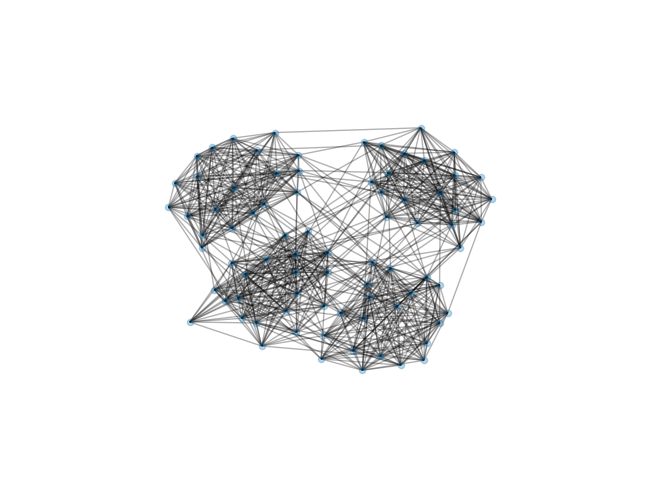

In [24]:
q = 5
N, T, p, q_1, q_2 = 80, 200 , 3, q, q
sizes = [int(N/4)] * 4
probs = [
    [0.85, 0.05, 0.05, 0.05],
    [0.05, 0.85, 0.05, 0.05],
    [0.05, 0.05, 0.85, 0.05],
    [0.05, 0.05, 0.05, 0.85]
]
G = nx.stochastic_block_model(sizes, probs)
nx.draw_kamada_kawai(G, node_size = 20, alpha=0.3, margins=0.4)
W = nx.to_numpy_array(G)
row_sums = W.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
W = W / row_sums

Z = np.random.normal(loc=0, scale=1, size=(N,T,p))

# Defining $\beta$

In [40]:
beta = np.random.rand(2*N*q+N*p,)[:, np.newaxis]/q
print(Stationnarity(beta,W,N,T,p,q))

[15.42194203 14.95743664 15.63871475 16.29068578 16.81760292]
0.22928273119697748
True


## Results with estimators
# OLS estimator

In [43]:
Y_first_q_terms = np.random.uniform(-10, 10, size=(N, q))
Y = np.zeros((N,T))
Y[0:N, 0:q] = Y_first_q_terms

for t in range(q+1, T+1):
    for i in range(1, N+1):
        Y[i-1][t-1] = compute_response_Y_t_node_i(Y, Z, W, t, q_1, q_2, beta, i) + np.random.normal(loc=0, scale=.5)
    
predicted_beta_OLS = compute_beta_OLS(Y, Z, W, q_1, q_2, testing = True)
print(Stationnarity(predicted_beta_OLS,W,N,T,p,q))

print("-")
scalar_prod = np.dot(predicted_beta_OLS.T, beta)[0,0]
cosin = scalar_prod / (np.linalg.norm(predicted_beta_OLS) * np.linalg.norm(beta))
print(f"cosin between vectors:",cosin)
print(f"norms:",np.linalg.norm(predicted_beta_OLS), "(predicted_beta_OLS) - ", np.linalg.norm(beta), "(beta)")
print(beta)
print(predicted_beta_OLS)

[16.6443001  15.51536343 14.39329011 15.7035069  15.82439748]
0.2797935244729954
True
-
cosin between vectors: 0.9050537660737399
norms: 3.563182451646613 (predicted_beta_OLS) -  3.6809752843605223 (beta)
[[0.12981449]
 [0.08944758]
 [0.13433534]
 ...
 [0.12015218]
 [0.15305134]
 [0.03177225]]
[[ 0.24548657]
 [ 0.03276875]
 [-0.00447871]
 ...
 [ 0.11438073]
 [ 0.11264182]
 [-0.0107378 ]]


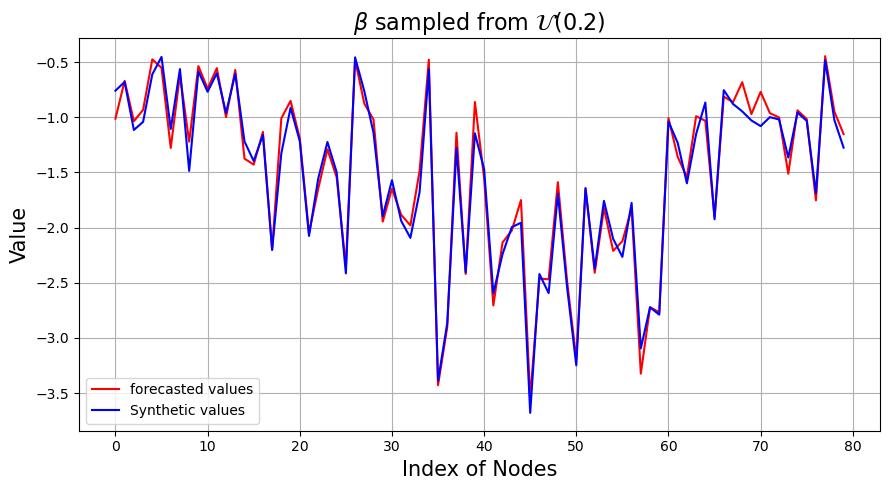

MSE of predicted beta: 0.013581272700005153
MAE of predicted beta: 0.08924025501874336


In [44]:
Y_final = np.ndarray(N)
Y_final_pred = np.ndarray(N)
for i in range(1, N+1):
    Y_final_pred[i-1] = compute_response_Y_t_node_i(Y, Z, W, T, q_1, q_2, predicted_beta_OLS, i)
    Y_final[i-1] = compute_response_Y_t_node_i(Y, Z, W, T, q_1, q_2, beta, i)
plt.figure(figsize=(9, 5))
plt.plot(Y_final_pred, color='r',label='forecasted values')
plt.plot(Y_final, color='b',label='Synthetic values')
plt.title(r'$\beta$ sampled from $\mathcal{U}(0.2)$',fontsize=16)
plt.xlabel('Index of Nodes',fontsize=15)
plt.ylabel('Value',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print('MSE of predicted beta:', mean_squared_error(Y_final_pred, Y_final))
print('MAE of predicted beta:', mean_absolute_error(Y_final_pred, Y_final))

# Validating the asymptotic distribution of the residuals
Remark: Please note that this code may take a considerable amount of time to render. For a quicker assessment of the model's performance, it is advisable to skip this section.

In [45]:
from scipy.stats import norm
alpha = 0.05
df = 2*N*q + N*p

# Mean and standard deviation for the normal approximation
mean = df
std_dev = (2 * df) ** 0.5

# Compute the quantiles for the normal distribution
l = norm.ppf(alpha / 2, loc=mean, scale=std_dev)
r = norm.ppf(1 - alpha / 2, loc=mean, scale=std_dev)

print(f"95% of the values need to be between ", l, " and ", r)
Y_first_q_terms = np.random.uniform(-10, 10, size=(N, q))
Y = np.zeros((N,T))
Y[0:N, 0:q] = Y_first_q_terms
Y_experiment = np.zeros((N,T))
Y_experiment[0:N, 0:q] = Y_first_q_terms

for t in range(q+1, T+1):
    for i in range(1, N+1):
        Y[i-1][t-1] = compute_response_Y_t_node_i(Y, Z, W, t, q_1, q_2, beta, i)

sigma =  0.01 * 0.01 * np.eye(N)
Q = 0
firstSum = np.zeros((2*N*q+N*p, 2*N*q+N*p))
for t in range(q+1,T+1):
    X_t_minus_1 = compute_X_t_minus_1(Y, Z, W, q_1, q_2, t)
    firstSum += X_t_minus_1.T @ X_t_minus_1
    X_sigma = X_t_minus_1.T @ sigma
    Q += X_sigma @ X_t_minus_1
    
Q /= (T-q)
blocks=[]
I_N_1 = (1/np.sqrt(T-q)) * 1 * np.eye(N)
I_N_2 = (1/np.sqrt(T-q)) * 2 * np.eye(N)
I_Np_3 = (1/np.sqrt(T-q)) * 1 * np.eye(N*p)
for i in range(0,q):
    blocks.append(I_N_1)
    blocks.append(I_N_2)
blocks.append(I_Np_3)
    
M = block_diag(*blocks)
firstSum += (T-q)*M
firstSum /= np.sqrt(T-q)

beta = compute_beta_OLS(Y, Z, W, q_1, q_2, testing = True)
prob = 0
D = [] 
for i in range(0,1000):
    for t in range(q+1, T+1):
        for k in range(1, N+1):
            Y_experiment[k-1][t-1] = Y[k-1][t-1] + np.random.normal(loc=0, scale=.01)
    predicted_beta_OLS = compute_beta_OLS(Y_experiment, Z, W, q_1, q_2, testing = True)
    
    diff_beta = (predicted_beta_OLS - beta)
    normal =  firstSum @ diff_beta
    Q_1_normal = np.dot(np.linalg.inv(Q), normal)
    D.append(np.dot(normal.T, Q_1_normal)[0,0])
    #print(f"D:",D[-1])
    #scalar_prod = np.dot(predicted_beta_OLS.T, beta)[0,0]
    #cosin = scalar_prod / (np.linalg.norm(predicted_beta_OLS) * np.linalg.norm(beta))
    #print(f"cosin between vectors:",cosin)
    #print(f"norms:",np.linalg.norm(predicted_beta_OLS), "(predicted_beta_OLS) - ", np.linalg.norm(beta), "(beta)")
    print(f"", i/10, "% : ", D[-1])
    if l < D[-1] < r:
        prob+=1
print(prob/10)

95% of the values need to be between  950.6118892299218  and  1129.3881107700784
 0.0 % :  1060.4766656717889
 0.1 % :  990.6581174339253
 0.2 % :  998.964282181411
 0.3 % :  965.2871810412395
 0.4 % :  984.9609798859696
 0.5 % :  1017.3032034962869
 0.6 % :  920.0831935888468
 0.7 % :  1040.151027173821
 0.8 % :  1070.162341158315
 0.9 % :  1067.8045170492019
 1.0 % :  1130.7038618317279
 1.1 % :  1008.356411993356
 1.2 % :  987.7278814314772
 1.3 % :  1045.9218565572803
 1.4 % :  965.4200222571253
 1.5 % :  964.8379976209926
 1.6 % :  1116.8486469602021
 1.7 % :  1045.520048632293
 1.8 % :  937.2195834243423
 1.9 % :  1002.494263794516
 2.0 % :  1071.593443108463
 2.1 % :  1091.465434826589
 2.2 % :  994.245331998943
 2.3 % :  991.8263724899757
 2.4 % :  932.8088281567897
 2.5 % :  1020.8455330071101
 2.6 % :  982.327382489936
 2.7 % :  983.5399593729967
 2.8 % :  1079.6869219725852
 2.9 % :  970.0126181050892
 3.0 % :  1020.4775168659347
 3.1 % :  1033.8661269036174
 3.2 % :  1090.1

 27.9 % :  1067.0135165664083
 28.0 % :  1018.6620533976575
 28.1 % :  1030.2580653870655
 28.2 % :  1143.6188117838744
 28.3 % :  1096.3999610949604
 28.4 % :  966.1302012712589
 28.5 % :  948.8400798827255
 28.6 % :  1055.9758177622398
 28.7 % :  1099.0806393276644
 28.8 % :  934.7115958989361
 28.9 % :  1010.5856905442928
 29.0 % :  1046.357301541435
 29.1 % :  1129.7045994030523
 29.2 % :  969.9248119996098
 29.3 % :  988.3953878530776
 29.4 % :  1009.6121949337312
 29.5 % :  1016.3097403332303
 29.6 % :  1110.9820799261015
 29.7 % :  1013.3710402225961
 29.8 % :  959.3586646478714
 29.9 % :  1024.5281326599843
 30.0 % :  921.5324229237186
 30.1 % :  973.0199927271854
 30.2 % :  1029.2813359304478
 30.3 % :  1005.3518934188321
 30.4 % :  1066.8663570639023
 30.5 % :  1159.511066526527
 30.6 % :  1032.2857992969975
 30.7 % :  1077.7008336451188
 30.8 % :  967.6957228234779
 30.9 % :  1079.551816239565
 31.0 % :  1038.019319651044
 31.1 % :  1093.0274196276398
 31.2 % :  1038.5979204

 55.8 % :  1061.2542933050665
 55.9 % :  979.0591006517582
 56.0 % :  1018.9417703359272
 56.1 % :  1020.2774710908091
 56.2 % :  1063.7950271317204
 56.3 % :  1107.3541847425824
 56.4 % :  1109.1689285570485
 56.5 % :  989.8680526292061
 56.6 % :  1066.8818647488788
 56.7 % :  1011.2625899817007
 56.8 % :  982.73808898024
 56.9 % :  1060.387407076439
 57.0 % :  967.6280832506254
 57.1 % :  997.2535383527926
 57.2 % :  1031.8391055029977
 57.3 % :  1033.4893819358158
 57.4 % :  1080.4098255909917
 57.5 % :  1019.267258406592
 57.6 % :  1026.2840122940534
 57.7 % :  1018.2383225655088
 57.8 % :  942.6028769250695
 57.9 % :  962.7475679909744
 58.0 % :  1034.1125151293438
 58.1 % :  990.7130015273169
 58.2 % :  1040.2809818124588
 58.3 % :  1045.9370902760056
 58.4 % :  1058.7082853801003
 58.5 % :  1074.3876747446386
 58.6 % :  953.5770628887267
 58.7 % :  998.4784104956518
 58.8 % :  997.5035841757405
 58.9 % :  1060.504542866801
 59.0 % :  1005.4407583787086
 59.1 % :  1097.7480857391

 83.6 % :  1013.2931716650121
 83.7 % :  1078.114958938408
 83.8 % :  1099.7502764847213
 83.9 % :  1048.850196258076
 84.0 % :  1104.109060342159
 84.1 % :  1057.708105111847
 84.2 % :  997.3594094135975
 84.3 % :  1091.3864096944806
 84.4 % :  1049.3007784472627
 84.5 % :  970.6558746752037
 84.6 % :  1096.9689841061677
 84.7 % :  1120.2041380350784
 84.8 % :  1015.193890840853
 84.9 % :  997.1668597470851
 85.0 % :  1059.4795336808481
 85.1 % :  969.9750831108046
 85.2 % :  1027.0922637079275
 85.3 % :  997.9962408211882
 85.4 % :  942.4103076677227
 85.5 % :  991.0156114761432
 85.6 % :  1033.2872603171822
 85.7 % :  977.6165038992478
 85.8 % :  1051.5085679094025
 85.9 % :  1068.7590452384004
 86.0 % :  986.3973936845712
 86.1 % :  932.948923056679
 86.2 % :  1062.1426663964905
 86.3 % :  979.391588080628
 86.4 % :  930.333587600706
 86.5 % :  997.8527496083644
 86.6 % :  971.2053963511217
 86.7 % :  1023.9611658140801
 86.8 % :  988.6331654239003
 86.9 % :  979.8691550159508
 87.

1021.8189162728765


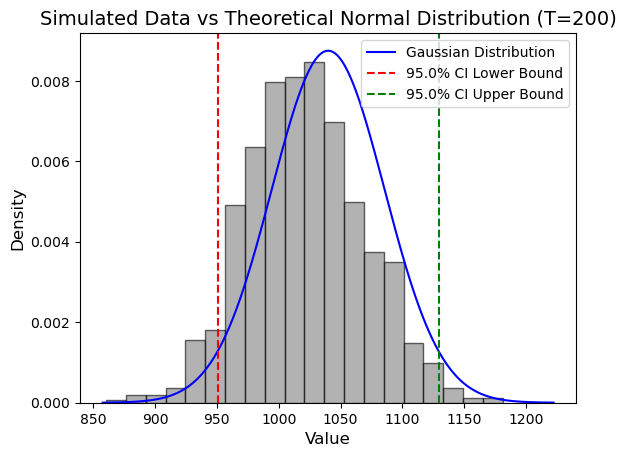

200


In [46]:
print(np.mean(D))
# Estimate parameters for the Gaussian distribution
mean = df
std_dev = (2 * df) ** 0.5

# Define the range for the x-axis
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# Plot Gaussian distribution
pdf = norm.pdf(x, loc=mean, scale=std_dev)
plt.plot(x, pdf, label='Gaussian Distribution', color='blue')

# Plot histogram of the data
plt.hist(D, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black')

# Confidence intervals
alpha = 0.05
l = norm.ppf(alpha / 2, loc=mean, scale=std_dev)
r = norm.ppf(1 - alpha / 2, loc=mean, scale=std_dev)

plt.axvline(l, color='red', linestyle='--', label=f'{100*(1-alpha):.1f}% CI Lower Bound')
plt.axvline(r, color='green', linestyle='--', label=f'{100*(1-alpha):.1f}% CI Upper Bound')

# Add labels and title
plt.xlabel('Value',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.title('Simulated Data vs Theoretical Normal Distribution (T=200)',fontsize=14)
plt.legend()

# Show plot
plt.show()
print(T)

# We add a Factor model error

0.2986904489627504
[[0.46475156 0.17703111 0.14454171 0.12260646 0.11656958]
 [0.17703111 0.68398794 0.18190165 0.15839645 0.16019022]
 [0.14454171 0.18190165 1.08447363 0.20166034 0.18111542]
 [0.12260646 0.15839645 0.20166034 0.83983331 0.13810538]
 [0.11656958 0.16019022 0.18111542 0.13810538 0.8875062 ]]


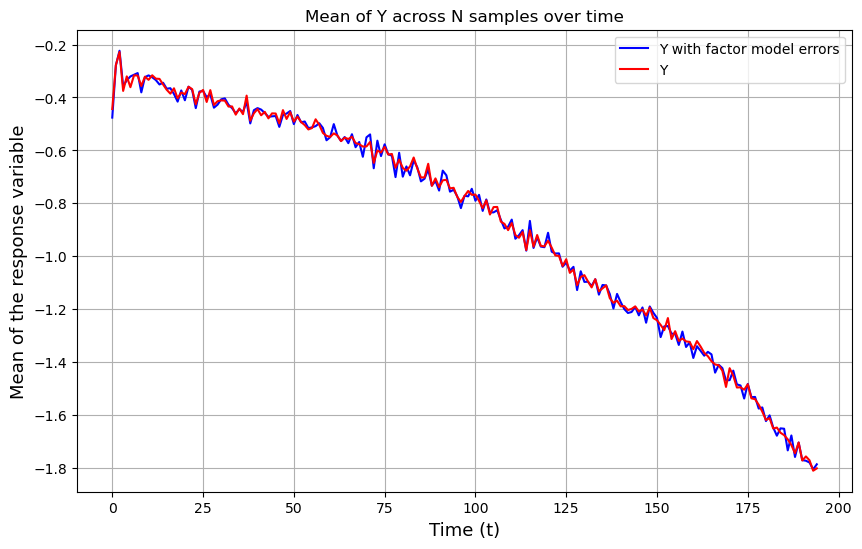

In [47]:
Y_FM = np.zeros((N,T))
Y_FM[0:N, 0:q] = Y_first_q_terms
r=5
F_F = np.zeros((r,r))
Lambda = np.random.uniform(low=-2, high=2, size=(N, r))

A = np.random.uniform(low=-1/r, high=1/r, size = (r,r))
print(np.max(np.abs(np.linalg.eigvals(A))))

C = np.random.rand(r, r)
covariance_matrix = np.dot(C.T, C)
mean = np.zeros(r) 
for i in range(r):
    covariance_matrix[i][i] = np.random.rand()*10 +1
covariance_matrix /= 10
print(covariance_matrix)


list_F = np.random.multivariate_normal(mean, covariance_matrix)

for t in range(q+1, T+1):
    list_F = A @ list_F + np.random.normal(loc=0, scale=.05,size=r)
    #list_F = np.random.multivariate_normal(mean, covariance_matrix)
    F_t = np.array(list_F)[:, np.newaxis]
    Lambda_F = np.dot(Lambda, F_t)
    F_F += np.dot(F_t,F_t.T)
    for i in range(1, N+1):
        Y_FM[i-1][t-1] = Y[i-1][t-1] + Lambda_F[i-1]
plt.figure(figsize=(10, 6))
plt.plot(Y_FM.mean(axis=0)[q:], color='b', label='Y with factor model errors')
plt.plot(Y.mean(axis=0)[q:], color='r', label='Y')
plt.xlabel('Time (t)',fontsize=13)
plt.ylabel('Mean of the response variable', fontsize=13)
plt.title('Mean of Y across N samples over time')
plt.grid(True)
plt.legend()
plt.show()

# Evaluate the FGLS with Factor-based error performance

OLS:
MSE: 0.0006339969096219855
MAE: 0.020656485958999198
---
GLS:
MSE: 0.001124966422469184
MAE: 0.026955945417312353
---
k:  2 - IC:  -2.8563671933292922
k:  3 - IC:  -2.956725268500599
k:  4 - IC:  -3.019643874539204
k:  5 - IC:  -3.0879278486379675
k:  6 - IC:  -3.14879270574318
k:  7 - IC:  -3.221216164190822
k:  8 - IC:  -3.2704763564881763
k:  9 - IC:  -3.3133662286061427
k:  10 - IC:  -3.338448532646043
r:  10
[15.43523642 15.47321647 15.71584481 15.9051834  16.69000965]
0.22176986546880048
True
Factor Model:
MSE: 0.0010734264118437316
MAE: 0.026706438232105556
---


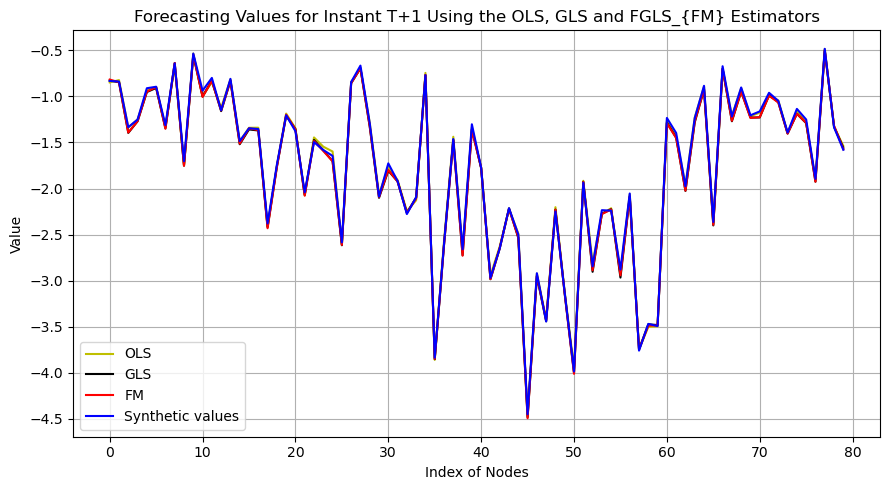

In [48]:
plt.figure(figsize=(9, 5))

Y_final = np.ndarray(N)
Y_final_pred = np.ndarray(N)
for i in range(1, N+1):
    list_F = A @ list_F + np.random.multivariate_normal(mean, covariance_matrix)
    F_t = np.array(list_F)[:, np.newaxis]
    Lambda_F = np.dot(Lambda, F_t)
    Y_final[i-1] = compute_response_Y_t_node_i(Y, Z, W, T, q_1, q_2, beta, i)
    

predicted_beta_OLS = compute_beta_OLS(Y_FM, Z, W, q_1, q_2,testing=True)
for i in range(1, N+1):
    Y_final_pred[i-1] = compute_response_Y_t_node_i(Y_FM, Z, W, T, q_1, q_2, predicted_beta_OLS, i)

print('OLS:')
print('MSE:', mean_squared_error(Y_final_pred, Y_final))
print('MAE:', mean_absolute_error(Y_final_pred, Y_final))
print('---')
plt.plot(Y_final_pred, color='y',label='OLS')

predicted_beta_GLS = compute_beta_FGLS(Y_FM, Z, W, W, q_1, q_2, model = "GLS",testing=True)
for i in range(1, N+1):
    Y_final_pred[i-1] = compute_response_Y_t_node_i(Y_FM, Z, W, T, q_1, q_2, predicted_beta_GLS, i)

print('GLS:')
print('MSE:', mean_squared_error(Y_final_pred, Y_final))
print('MAE:', mean_absolute_error(Y_final_pred, Y_final))
print('---')
plt.plot(Y_final_pred, color='black',label='GLS')

predicted_beta_FM = compute_beta_FGLS(Y_FM, Z, W, W, q_1, q_2,testing=True, l_1=1, l_2=2, l_3=1)
print(Stationnarity(predicted_beta_FM,W,N,T,p,q))
for i in range(1, N+1):
    Y_final_pred[i-1] = compute_response_Y_t_node_i(Y_FM, Z, W, T, q_1, q_2, predicted_beta_FM, i)

print('Factor Model:')
print('MSE:', mean_squared_error(Y_final_pred, Y_final))
print('MAE:', mean_absolute_error(Y_final_pred, Y_final))
print('---')
plt.plot(Y_final_pred, color='r',label='FM')
plt.plot(Y_final, color='b',label='Synthetic values')
plt.title('Forecasting Values for Instant T+1 Using the OLS, GLS and FGLS_{FM} Estimators')
plt.xlabel('Index of Nodes')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# We add to the initial Y a spatial structured error

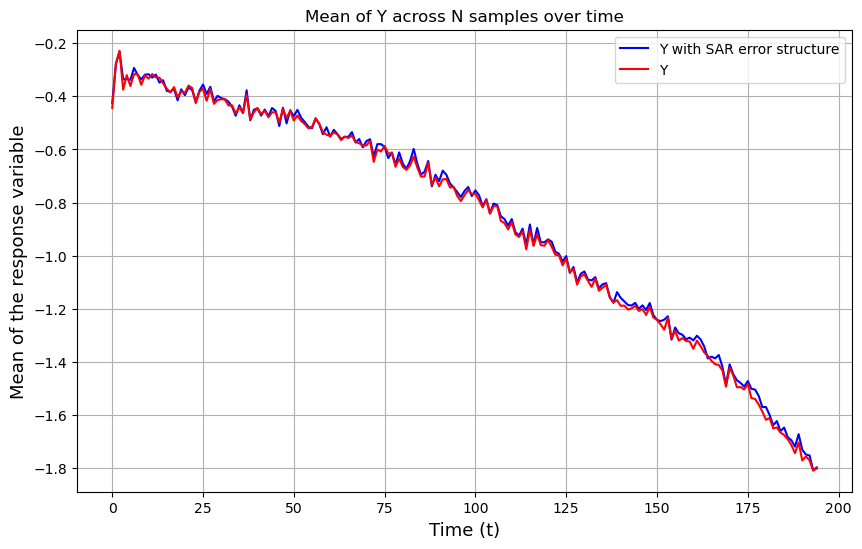

In [49]:
rho = .5

sizes = [int(N/4)] * 4
probs = [
    [0.94, 0.02, 0.02, 0.02],
    [0.02, 0.94, 0.02, 0.02],
    [0.02, 0.02, 0.94, 0.02],
    [0.02, 0.02, 0.02, 0.94]
]
G = nx.stochastic_block_model(sizes, probs)
Phi = nx.to_numpy_array(G)
row_sums = Phi.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
Phi = Phi / row_sums
I_Phi = np.linalg.inv(np.eye(N) - rho * Phi)

Y_SAR = np.zeros((N,T))
Y_SAR[0:N, 0:q] = Y_first_q_terms


for t in range(q+1, T+1):
    u_t = np.random.normal(loc=0, scale=.05, size=(N, 1))
    er_t = np.dot(I_Phi, u_t)
    for i in range(1, N+1):
        Y_SAR[i-1][t-1] = compute_response_Y_t_node_i(Y, Z, W, t, q_1, q_2, beta, i) + er_t[i-1]
        

plt.figure(figsize=(10, 6))
plt.plot(Y_SAR.mean(axis=0)[q:], color='b', label='Y with SAR error structure')
plt.plot(Y.mean(axis=0)[q:], color='r', label='Y')
plt.xlabel('Time (t)',fontsize=13)
plt.ylabel('Mean of the response variable', fontsize=13)
plt.title('Mean of Y across N samples over time')
plt.grid(True)
plt.legend()
plt.show()

# Evaluate the FGLS estimator with spatial autoregressive (SAR) error structure

OLS:
MSE: 0.002983187108653652
MAE: 0.04421767543361934
---
GLS:
MSE: 0.0028933261445496508
MAE: 0.04351470759992786
---
rho estimated: 0.4221050593517947
[16.36931949 15.79949399 15.24177671 15.64032699 15.39727287]
0.22568517813420366
True
SAR:
MSE: 0.002558194063546691
MAE: 0.04039304839806783
---


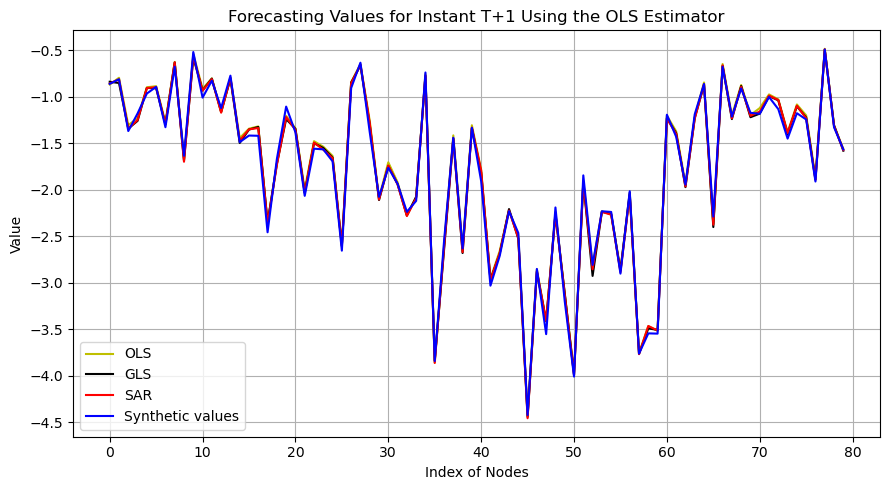

In [50]:
plt.figure(figsize=(9, 5))

Y_final = np.ndarray(N)
Y_final_pred = np.ndarray(N)
for i in range(1, N+1):
    u_t = np.random.normal(loc=0, scale=.05, size=(N, 1))
    er_t = np.dot(I_Phi, u_t)
    Y_final[i-1] = compute_response_Y_t_node_i(Y, Z, W, T, q_1, q_2, beta, i) + er_t[i-1]
    

predicted_beta_OLS = compute_beta_OLS(Y_SAR, Z, W, q_1, q_2,testing=True)
for i in range(1, N+1):
    Y_final_pred[i-1] = compute_response_Y_t_node_i(Y_SAR, Z, W, T, q_1, q_2, predicted_beta_OLS, i)

print('OLS:')
print('MSE:', mean_squared_error(Y_final_pred, Y_final))
print('MAE:', mean_absolute_error(Y_final_pred, Y_final))
print('---')
plt.plot(Y_final_pred, color='y',label='OLS')

predicted_beta_GLS = compute_beta_FGLS(Y_SAR, Z, W, W, q_1, q_2, model = "GLS",testing=True)
for i in range(1, N+1):
    Y_final_pred[i-1] = compute_response_Y_t_node_i(Y_SAR, Z, W, T, q_1, q_2, predicted_beta_GLS, i)

print('GLS:')
print('MSE:', mean_squared_error(Y_final_pred, Y_final))
print('MAE:', mean_absolute_error(Y_final_pred, Y_final))
print('---')
plt.plot(Y_final_pred, color='black',label='GLS')

predicted_beta_FM = compute_beta_FGLS(Y_SAR, Z, W, W, q_1, q_2, model = "SAR", testing=True)
print(Stationnarity(predicted_beta_FM,W,N,T,p,q))
for i in range(1, N+1):
    Y_final_pred[i-1] = compute_response_Y_t_node_i(Y_SAR, Z, W, T, q_1, q_2, predicted_beta_FM, i)

print('SAR:')
print('MSE:', mean_squared_error(Y_final_pred, Y_final))
print('MAE:', mean_absolute_error(Y_final_pred, Y_final))
print('---')
plt.plot(Y_final_pred, color='r',label='SAR')
plt.plot(Y_final, color='b',label='Synthetic values')
plt.title('Forecasting Values for Instant T+1 Using the OLS Estimator')
plt.xlabel('Index of Nodes')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()